In [114]:
import scipy as tf
print(tf.__version__)

1.5.4


In [15]:
#!pip uninstall -y tensorflow-gpu tensorflow keras
#!pip install --upgrade pip
#!pip install  --upgrade --force-reinstall keras tensorflow-gpu
#!pip install verta
#!pip install numpy
#!pip install sklearn
#!pip install scipy

In [16]:
%matplotlib inline
import os,random
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import pickle as cPickle, random, sys
import scipy
from sklearn import preprocessing
import tensorflow as tf
from numpy.fft import *


import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# import tensorflow as tf



In [17]:
#import verta
from verta import Client
client = Client('http://138.75.233.102:3000')

connection successfully established


In [51]:
proj = client.set_project("Deepsig IQ data Detection")


created new Project: Deepsig IQ data Detection in personal workspace
created new Experiment: Time series Classification


In [52]:
Xd = cPickle.load(open("RML2016.10b.dat",'rb'), encoding='latin1')

In [53]:
INTENSITY_AXIS=0
QUADRATURE_AXIS=1

snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])


In [54]:
X_Intensity = []  
X_Quadrature = []
Label_strings = []
for mod in mods:
    X_Intensity.append(Xd[(mod,18)][:,INTENSITY_AXIS,:])
    X_Quadrature.append(Xd[(mod,18)][:,QUADRATURE_AXIS,:])
    for label in range(len(Xd[(mod,18)][:,INTENSITY_AXIS,:])):
        Label_strings.append(mod)
        
X_Intensity = np.vstack(X_Intensity) # Quick way to create stacked dataset
X_Quadrature = np.vstack(X_Quadrature)
Label_strings=np.vstack(Label_strings)
complex_num = X_Intensity + 1j*X_Quadrature

le= preprocessing.LabelEncoder()
le.fit(Label_strings)
Label= le.transform(Label_strings)
depth = 10
Label = tf.one_hot(Label,depth)


In [55]:
Label_strings

array([['8PSK'],
       ['8PSK'],
       ['8PSK'],
       ...,
       ['WBFM'],
       ['WBFM'],
       ['WBFM']], dtype='<U6')

In [110]:
print((mods))

['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


In [57]:
np.random.seed(2016)
X_Intensity_Dataset = np.c_[X_Intensity, Label]
X_Intensity_Dataset.shape

(60000, 138)

In [58]:
import copy
X_Intensity_Dataset_Label_shuffled = copy.copy(X_Intensity_Dataset)
np.random.shuffle(X_Intensity_Dataset_Label_shuffled)

In [59]:
length_of_X_train = int(0.7*X_Intensity_Dataset_Label_shuffled.shape[0]) #42000
length_of_X_validation = (int(0.2*X_Intensity_Dataset_Label_shuffled.shape[0]))+length_of_X_train #12000
print(length_of_X_validation)

54000


In [60]:
Train_Intensity_Dataset = X_Intensity_Dataset_Label_shuffled[0:length_of_X_train,0:128]
Y_Train_Intensity_Dataset = X_Intensity_Dataset_Label_shuffled[0:length_of_X_train,128:]

Validation_Intensity_Dataset = X_Intensity_Dataset_Label_shuffled[length_of_X_train:length_of_X_validation,0:128]
Y_Validation_Intensity_Dataset = X_Intensity_Dataset_Label_shuffled[length_of_X_train:length_of_X_validation,128:]

Validation_Intensity_Dataset.shape


(12000, 128)

In [61]:

print(Y_Train_Intensity_Dataset.shape)

(42000, 10)


In [91]:
# Y_train.shape
BATCH_SIZE = 100
expt = client.set_experiment("Convolution 1D ")
run_2 = client.set_experiment_run("Convolution 1D_drop0.1_5Layers")
run_2.log_hyperparameter("num_layers", 5)
run_2.log_hyperparameter("dropout", 0.1)

got existing Experiment: Convolution 1D 
created new ExperimentRun: Convolution 1D_drop0.1_5Layers


In [92]:
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GlobalMaxPooling1D,Conv1D,MaxPooling1D
model_m = Sequential()
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(128,1)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalMaxPooling1D())
model_m.add(Dropout(0.1))
model_m.add(Dense(10, activation='softmax'))
print(model_m.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 119, 100)          1100      
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 110, 100)          100100    
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 36, 100)           0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 27, 160)           160160    
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 18, 160)           256160    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 160)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 160)              

In [93]:
model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

In [94]:

Train_Intensity_Dataset=Train_Intensity_Dataset.reshape(42000,128,1)
Validation_Intensity_Dataset=Validation_Intensity_Dataset.reshape(12000,128,1)
print(Validation_Intensity_Dataset.shape)

(12000, 128, 1)


In [95]:
EPOCHS = 300
history = model_m.fit(Train_Intensity_Dataset,
                      Y_Train_Intensity_Dataset,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                     validation_data=(Validation_Intensity_Dataset, Y_Validation_Intensity_Dataset),
                    callbacks = [tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

Epoch 1/300
420/420 [==============================] - 3s 6ms/step - loss: 1.5867 - accuracy: 0.3690 - val_loss: 1.2655 - val_accuracy: 0.4820
Epoch 2/300
420/420 [==============================] - 3s 6ms/step - loss: 1.0715 - accuracy: 0.5386 - val_loss: 0.9072 - val_accuracy: 0.5979
Epoch 3/300
420/420 [==============================] - 3s 6ms/step - loss: 0.8902 - accuracy: 0.6073 - val_loss: 0.8305 - val_accuracy: 0.6323
Epoch 4/300
420/420 [==============================] - 3s 6ms/step - loss: 0.8228 - accuracy: 0.6342 - val_loss: 0.7887 - val_accuracy: 0.6368
Epoch 5/300
420/420 [==============================] - 3s 6ms/step - loss: 0.7843 - accuracy: 0.6508 - val_loss: 0.7511 - val_accuracy: 0.6572
Epoch 6/300
420/420 [==============================] - 3s 6ms/step - loss: 0.7504 - accuracy: 0.6639 - val_loss: 0.7374 - val_accuracy: 0.6624
Epoch 7/300
420/420 [==============================] - 3s 6ms/step - loss: 0.7323 - accuracy: 0.6712 - val_loss: 0.7132 - val_accuracy: 0.6722

In [96]:
_, accuracy = model_m.evaluate(Validation_Intensity_Dataset, Y_Validation_Intensity_Dataset)
print('Accuracy: %.2f' % (accuracy*100))


run_2.log_metric("accuracy", accuracy)
run_2.log_tags(["Experiment_dropout0.1_5Layers"])


375/375 [==============================] - 1s 2ms/step - loss: 0.6491 - accuracy: 0.7209
Accuracy: 72.09


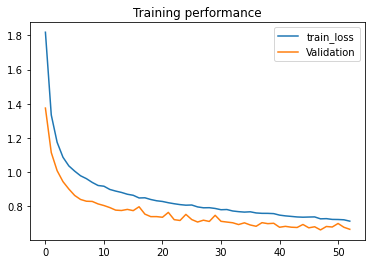

In [19]:
plt.figure()
plt.title('Training performance')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()



In [101]:
import copy
X_Dataset = np.c_[X_Intensity,X_Quadrature, Label]

X_Dataset_Label_shuffled = copy.copy(X_Dataset)
np.random.shuffle(X_Dataset_Label_shuffled)

length_of_X_train = int(0.7*X_Dataset_Label_shuffled.shape[0]) #42000
length_of_X_validation = (int(0.2*X_Dataset_Label_shuffled.shape[0]))+length_of_X_train #12000


Train_Dataset = X_Dataset_Label_shuffled[0:length_of_X_train,0:256]
Y_Train_Dataset = X_Dataset_Label_shuffled[0:length_of_X_train,256:]

Validation_Dataset = X_Dataset_Label_shuffled[length_of_X_train:length_of_X_validation,0:256]
Y_Validation_Dataset = X_Dataset_Label_shuffled[length_of_X_train:length_of_X_validation,256:]

Test_Dataset = X_Dataset_Label_shuffled[length_of_X_validation:,0:256]
Y_Test_Dataset= X_Dataset_Label_shuffled[length_of_X_validation:,256:]

print(X_Dataset_Label_shuffled.shape)

print(Train_Dataset.shape)

print(Validation_Dataset.shape)

print(Test_Dataset.shape)

(60000, 266)
(42000, 256)
(12000, 256)
(6000, 256)


In [97]:
expt = client.set_experiment("Convolution 1D With I & Q ")
run_2 = client.set_experiment_run("Convolution 1D_IQ_drop0.1_5Layers")
run_2.log_hyperparameter("num_layers", 5)
run_2.log_hyperparameter("dropout", 0.1)

created new Experiment: Convolution 1D With I & Q 
created new ExperimentRun: Convolution 1D_IQ_drop0.1_5Layers


In [98]:
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GlobalMaxPooling1D,Conv1D,MaxPooling1D

model_Dataset = Sequential()
model_Dataset.add(Conv1D(100, 10, activation='relu', input_shape=(256,1)))
model_Dataset.add(Conv1D(100, 10, activation='relu'))
model_Dataset.add(MaxPooling1D(3))
model_Dataset.add(Conv1D(160, 10, activation='relu'))
model_Dataset.add(Conv1D(160, 10, activation='relu'))
model_Dataset.add(GlobalMaxPooling1D())
model_Dataset.add(Dropout(0.5))
model_Dataset.add(Dense(10, activation='softmax'))
print(model_Dataset.summary())

model_Dataset.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_39 (Conv1D)           (None, 247, 100)          1100      
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 238, 100)          100100    
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 79, 100)           0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 70, 160)           160160    
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 61, 160)           256160    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 160)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 160)              

In [103]:
Train_Dataset=Train_Dataset.reshape(42000,256,1)
Validation_Dataset=Validation_Dataset.reshape(12000,256,1)
#Test_Dataset = Test_Dataset.reshape(1536000,256,1)


In [104]:
EPOCHS = 300
history_Dataset = model_Dataset.fit(Train_Dataset,
                      Y_Train_Dataset,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(Validation_Dataset, Y_Validation_Dataset),
                    callbacks =[tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')])

Epoch 1/300
420/420 [==============================] - 5s 11ms/step - loss: 1.5319 - accuracy: 0.3859 - val_loss: 1.0575 - val_accuracy: 0.5634
Epoch 2/300
420/420 [==============================] - 5s 11ms/step - loss: 1.0278 - accuracy: 0.5683 - val_loss: 0.8277 - val_accuracy: 0.6531
Epoch 3/300
420/420 [==============================] - 5s 11ms/step - loss: 0.9143 - accuracy: 0.6060 - val_loss: 0.7891 - val_accuracy: 0.6290
Epoch 4/300
420/420 [==============================] - 5s 11ms/step - loss: 0.8499 - accuracy: 0.6336 - val_loss: 0.7142 - val_accuracy: 0.6893
Epoch 5/300
420/420 [==============================] - 5s 11ms/step - loss: 0.8201 - accuracy: 0.6401 - val_loss: 0.6934 - val_accuracy: 0.7058
Epoch 6/300
420/420 [==============================] - 5s 11ms/step - loss: 0.7843 - accuracy: 0.6531 - val_loss: 0.6819 - val_accuracy: 0.7108
Epoch 7/300
420/420 [==============================] - 5s 11ms/step - loss: 0.7659 - accuracy: 0.6600 - val_loss: 0.6509 - val_accuracy:

420/420 [==============================] - 5s 12ms/step - loss: 0.4953 - accuracy: 0.7620 - val_loss: 0.4633 - val_accuracy: 0.7746
Epoch 55/300
420/420 [==============================] - 5s 12ms/step - loss: 0.4974 - accuracy: 0.7620 - val_loss: 0.4633 - val_accuracy: 0.7756
Epoch 56/300
420/420 [==============================] - 5s 12ms/step - loss: 0.4910 - accuracy: 0.7630 - val_loss: 0.4564 - val_accuracy: 0.7754
Epoch 57/300
420/420 [==============================] - 5s 12ms/step - loss: 0.4874 - accuracy: 0.7654 - val_loss: 0.4671 - val_accuracy: 0.7832
Epoch 58/300
420/420 [==============================] - 5s 12ms/step - loss: 0.4891 - accuracy: 0.7648 - val_loss: 0.4544 - val_accuracy: 0.7866
Epoch 59/300
420/420 [==============================] - 5s 12ms/step - loss: 0.4763 - accuracy: 0.7688 - val_loss: 0.4450 - val_accuracy: 0.7873
Epoch 60/300
420/420 [==============================] - 5s 12ms/step - loss: 0.4794 - accuracy: 0.7677 - val_loss: 0.4375 - val_accuracy: 0.784

In [105]:
_, accuracy = model_Dataset.evaluate(Validation_Dataset, Y_Validation_Dataset)
print('Accuracy: %.2f' % (accuracy*100))

run_2.log_metric("accuracy", accuracy)
run_2.log_tags(["Experiment_IQ_dropout0.1_5Layers"])

375/375 [==============================] - 1s 2ms/step - loss: 0.4386 - accuracy: 0.7907
Accuracy: 79.07


In [106]:
model_Dataset.save("Convolution 1D_IQ_drop0.1_5Layers")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Convolution 1D_IQ_drop0.1_5Layers/assets


In [113]:
from tensorflow import keras
loadedmodel = keras.models.load_model("Convolution 1D_IQ_drop0.1_5Layers")
np.argmax(loadedmodel.predict(Validation_Dataset[:5]),axis=1)

array([7, 5, 0, 9, 0])

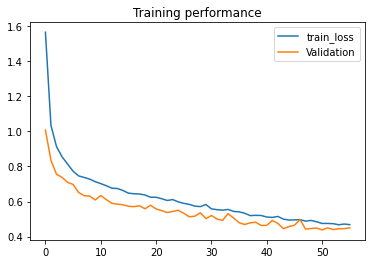

In [26]:
plt.figure()
plt.title('Training performance')
plt.plot(history_Dataset.history['loss'], label='train_loss')
plt.plot(history_Dataset.history['val_loss'], label='Validation')
plt.legend()
plt.show()

In [22]:
%matplotlib inline
import os,random
# os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
import numpy as np
# import theano as th
# import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as cPickle, random, sys, keras


in_shp = [2,128]
print(Train_Dataset.shape)

(42000, 256, 1)


In [23]:
model_4wave = keras.Sequential()
model_4wave.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[256, 1]
      )
    )
)
model_4wave.add(keras.layers.Dropout(rate=0.2))
model_4wave.add(keras.layers.Dense(units=128, activation='relu'))
model_4wave.add(keras.layers.Dense(10, activation='softmax'))
model_4wave.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])



In [24]:
#model_4wave.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [25]:
Train_Dataset=Train_Dataset.reshape(42000,256,1)
Validation_Dataset=Validation_Dataset.reshape(12000,256,1)


In [26]:
history = model_4wave.fit(
    Train_Dataset,Y_Train_Dataset ,
    epochs=10,
    batch_size=100
)

Epoch 1/10
420/420 [==============================] - 12s 28ms/step - loss: 2.2988 - acc: 0.1070
Epoch 2/10
420/420 [==============================] - 12s 28ms/step - loss: 2.2875 - acc: 0.1250
Epoch 3/10
420/420 [==============================] - 12s 28ms/step - loss: 2.3025 - acc: 0.1341
Epoch 4/10
420/420 [==============================] - 12s 29ms/step - loss: 2.2377 - acc: 0.1445
Epoch 5/10
420/420 [==============================] - 12s 29ms/step - loss: 2.1049 - acc: 0.1700
Epoch 6/10
420/420 [==============================] - 12s 29ms/step - loss: 2.0156 - acc: 0.1876
Epoch 7/10
420/420 [==============================] - 12s 29ms/step - loss: 2.0887 - acc: 0.1736
Epoch 8/10
420/420 [==============================] - 12s 29ms/step - loss: 2.0766 - acc: 0.1754
Epoch 9/10
420/420 [==============================] - 12s 29ms/step - loss: 2.0028 - acc: 0.1947
Epoch 10/10
420/420 [==============================] - 12s 29ms/step - loss: 1.9906 - acc: 0.1934


In [70]:
from keras.layers import Input,Reshape,ZeroPadding2D,Conv2D,Dropout,Flatten,Dense,Activation,MaxPooling2D,AlphaDropout
import numpy as np
import os,random
from keras.layers import Input,Reshape,ZeroPadding2D,Conv2D,Dropout,Flatten,Dense,Activation,MaxPooling2D,AlphaDropout
from keras import layers
import keras.models as Model
from keras.regularizers import *
import seaborn as sns
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import gc
%matplotlib inline
os.environ["KERAS_BACKEND"] = "tensorflow"
data_format = 'channels_first'

classes=[1,2,3,4,5,6,7,8,9,10]
def residual_stack(Xm,kennel_size,Seq,pool_size):
    #1*1 Conv Linear
    Xm = Conv2D(32, (1, 1), padding='same', name=Seq+"_conv1", kernel_initializer='glorot_normal',data_format=data_format)(Xm)
    #Residual Unit 1
    Xm_shortcut = Xm
    Xm = Conv2D(32, kennel_size, padding='same',activation="relu",name=Seq+"_conv2", kernel_initializer='glorot_normal',data_format=data_format)(Xm)
    Xm = Conv2D(32, kennel_size, padding='same', name=Seq+"_conv3", kernel_initializer='glorot_normal',data_format=data_format)(Xm)
    Xm = layers.add([Xm,Xm_shortcut])
    Xm = Activation("relu")(Xm)
    #Residual Unit 2
    Xm_shortcut = Xm
    Xm = Conv2D(32, kennel_size, padding='same',activation="relu",name=Seq+"_conv4", kernel_initializer='glorot_normal',data_format=data_format)(Xm)
    X = Conv2D(32, kennel_size, padding='same', name=Seq+"_conv5", kernel_initializer='glorot_normal',data_format=data_format)(Xm)
    Xm = layers.add([Xm,Xm_shortcut])
    Xm = Activation("relu")(Xm)
    #MaxPooling
    Xm = MaxPooling2D(pool_size=pool_size, strides=pool_size, padding='valid', data_format=data_format)(Xm)
    return Xm


in_shp = Train_Dataset.shape[1:] 


#input layer

Xm_input = Input(in_shp)
Xm = Reshape([1,256,1], input_shape=in_shp)(Xm_input)

#Residual Srack
Xm = residual_stack(Xm,kennel_size=(3,2),Seq="ReStk0",pool_size=(2,1)) 
Xm = residual_stack(Xm,kennel_size=(3,1),Seq="ReStk1",pool_size=(2,1))
Xm = residual_stack(Xm,kennel_size=(3,1),Seq="ReStk2",pool_size=(2,1))  
Xm = residual_stack(Xm,kennel_size=(3,1),Seq="ReStk3",pool_size=(2,1)) 
Xm = residual_stack(Xm,kennel_size=(3,1),Seq="ReStk4",pool_size=(2,1)) 
Xm = residual_stack(Xm,kennel_size=(3,1),Seq="ReStk5",pool_size=(2,1))   


#Full Con 1
Xm = Flatten(data_format=data_format)(Xm)
Xm = Dense(128, activation='selu', kernel_initializer='glorot_normal', name="dense1")(Xm)
Xm = AlphaDropout(0.3)(Xm)
#Full Con 2
Xm = Dense(len(classes), kernel_initializer='glorot_normal', name="dense2")(Xm)
#SoftMax
Xm = Activation('softmax')(Xm)
#Create Model
model = Model.Model(inputs=Xm_input,outputs=Xm)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics='accuracy')
model.summary()


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
reshape_9 (Reshape)             (None, 1, 256, 1)    0           input_9[0][0]                    
__________________________________________________________________________________________________
ReStk0_conv1 (Conv2D)           (None, 32, 256, 1)   64          reshape_9[0][0]                  
__________________________________________________________________________________________________
ReStk0_conv2 (Conv2D)           (None, 32, 256, 1)   6176        ReStk0_conv1[0][0]               
_______________________________________________________________________________________

In [71]:
history = model.fit(Train_Dataset,
    Y_Train_Dataset,
    batch_size=100,
    epochs=600)

Epoch 1/600
420/420 [==============================] - 3s 7ms/step - loss: 1.4509 - accuracy: 0.3987
Epoch 2/600
420/420 [==============================] - 3s 7ms/step - loss: 0.9739 - accuracy: 0.5693
Epoch 3/600
420/420 [==============================] - 3s 7ms/step - loss: 0.8937 - accuracy: 0.6011
Epoch 4/600
420/420 [==============================] - 3s 7ms/step - loss: 0.8362 - accuracy: 0.6256
Epoch 5/600
420/420 [==============================] - 3s 7ms/step - loss: 0.7813 - accuracy: 0.6473
Epoch 6/600
420/420 [==============================] - 3s 7ms/step - loss: 0.7519 - accuracy: 0.6624
Epoch 7/600
420/420 [==============================] - 3s 7ms/step - loss: 0.7301 - accuracy: 0.6692
Epoch 8/600
420/420 [==============================] - 3s 7ms/step - loss: 0.8753 - accuracy: 0.6221
Epoch 9/600
420/420 [==============================] - 3s 7ms/step - loss: 0.7378 - accuracy: 0.6707
Epoch 10/600
420/420 [==============================] - 3s 8ms/step - loss: 0.7302 - accura

Epoch 81/600
420/420 [==============================] - 3s 7ms/step - loss: 0.3044 - accuracy: 0.8418
Epoch 82/600
420/420 [==============================] - 3s 8ms/step - loss: 0.3073 - accuracy: 0.8419
Epoch 83/600
420/420 [==============================] - 3s 7ms/step - loss: 0.3189 - accuracy: 0.8363
Epoch 84/600
420/420 [==============================] - 3s 7ms/step - loss: 0.2950 - accuracy: 0.8457
Epoch 85/600
420/420 [==============================] - 3s 7ms/step - loss: 0.3071 - accuracy: 0.8413
Epoch 86/600
420/420 [==============================] - 3s 8ms/step - loss: 0.2975 - accuracy: 0.8450
Epoch 87/600
420/420 [==============================] - 3s 8ms/step - loss: 0.3059 - accuracy: 0.8416
Epoch 88/600
420/420 [==============================] - 3s 7ms/step - loss: 0.3000 - accuracy: 0.8440
Epoch 89/600
420/420 [==============================] - 3s 7ms/step - loss: 0.3130 - accuracy: 0.8397
Epoch 90/600
420/420 [==============================] - 3s 7ms/step - loss: 0.3072

420/420 [==============================] - 3s 7ms/step - loss: 0.2155 - accuracy: 0.8894
Epoch 240/600
420/420 [==============================] - 3s 8ms/step - loss: 0.1986 - accuracy: 0.8988
Epoch 241/600
420/420 [==============================] - 3s 8ms/step - loss: 0.1923 - accuracy: 0.9009
Epoch 242/600
420/420 [==============================] - 3s 8ms/step - loss: 0.2039 - accuracy: 0.8956
Epoch 243/600
420/420 [==============================] - 3s 7ms/step - loss: 0.1882 - accuracy: 0.9025
Epoch 244/600
420/420 [==============================] - 3s 8ms/step - loss: 0.2020 - accuracy: 0.8970
Epoch 245/600
420/420 [==============================] - 3s 7ms/step - loss: 0.1990 - accuracy: 0.8969
Epoch 246/600
420/420 [==============================] - 3s 8ms/step - loss: 0.2201 - accuracy: 0.8912
Epoch 247/600
420/420 [==============================] - 3s 7ms/step - loss: 0.1920 - accuracy: 0.9009
Epoch 248/600
420/420 [==============================] - 3s 8ms/step - loss: 0.1917 - a

420/420 [==============================] - 3s 7ms/step - loss: 0.1719 - accuracy: 0.9119
Epoch 398/600
420/420 [==============================] - 3s 7ms/step - loss: 0.1835 - accuracy: 0.9075
Epoch 399/600
420/420 [==============================] - 3s 8ms/step - loss: 0.1805 - accuracy: 0.9102
Epoch 400/600
420/420 [==============================] - 3s 8ms/step - loss: 0.1753 - accuracy: 0.9089
Epoch 401/600
420/420 [==============================] - 3s 7ms/step - loss: 0.1819 - accuracy: 0.9094
Epoch 402/600
420/420 [==============================] - 3s 8ms/step - loss: 0.1845 - accuracy: 0.9072
Epoch 403/600
420/420 [==============================] - 3s 7ms/step - loss: 0.1725 - accuracy: 0.9126
Epoch 404/600
420/420 [==============================] - 3s 8ms/step - loss: 0.1596 - accuracy: 0.9179
Epoch 405/600
420/420 [==============================] - 3s 8ms/step - loss: 0.1790 - accuracy: 0.9085
Epoch 406/600
420/420 [==============================] - 3s 7ms/step - loss: 0.1584 - a

420/420 [==============================] - 3s 8ms/step - loss: 0.1606 - accuracy: 0.9173
Epoch 556/600
420/420 [==============================] - ETA: 0s - loss: 0.1532 - accuracy: 0.91 - 3s 8ms/step - loss: 0.1533 - accuracy: 0.9194
Epoch 557/600
420/420 [==============================] - 3s 8ms/step - loss: 0.1610 - accuracy: 0.9180
Epoch 558/600
420/420 [==============================] - 3s 8ms/step - loss: 0.1629 - accuracy: 0.9175
Epoch 559/600
420/420 [==============================] - 3s 7ms/step - loss: 0.1646 - accuracy: 0.9163
Epoch 560/600
420/420 [==============================] - 3s 8ms/step - loss: 0.1643 - accuracy: 0.9157
Epoch 561/600
420/420 [==============================] - 3s 8ms/step - loss: 0.1518 - accuracy: 0.9213
Epoch 562/600
420/420 [==============================] - 3s 7ms/step - loss: 0.1726 - accuracy: 0.9141
Epoch 563/600
420/420 [==============================] - 3s 8ms/step - loss: 0.1633 - accuracy: 0.9162
Epoch 564/600
420/420 [======================

In [72]:
_, accuracy = model.evaluate(Validation_Dataset, Y_Validation_Dataset)
print('Accuracy: %.2f' % (accuracy*100))

375/375 [==============================] - 1s 4ms/step - loss: 1.2490 - accuracy: 0.7971
Accuracy: 79.71


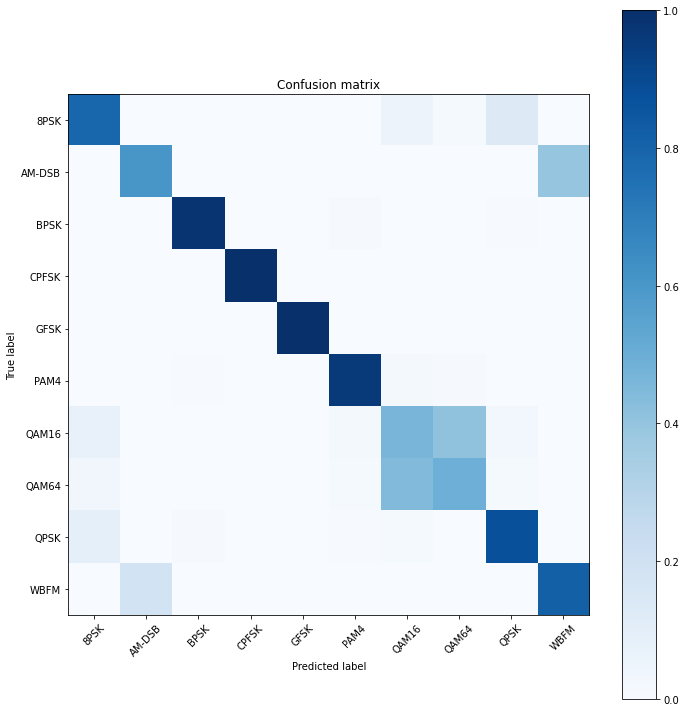

In [73]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Plot confusion matrix
batch_size = 1024
test_Y_hat = model.predict(Validation_Dataset, batch_size=1024)
conf = np.zeros([len(mods),len(mods)])
confnorm = np.zeros([len(mods),len(mods)])
for i in range(0,Validation_Dataset.shape[0]):
    j = list(Y_Validation_Dataset[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(mods)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=mods)

In [74]:
for i in range(len(confnorm)):
    print(mods[i],confnorm[i,i])

8PSK 0.7895667550839964
AM-DSB 0.6027049873203719
BPSK 0.9835661462612982
CPFSK 1.0
GFSK 1.0
PAM4 0.9644970414201184
QAM16 0.4680511182108626
QAM64 0.49355877616747185
QPSK 0.8761583824768323
WBFM 0.8140116763969975
